# Exercises - GEO4902-02 - Data Assimilation

Kjersti Stangeland, Fall 2024

# Exercise 02-04 - Understanding model and observation errors

This script (1) visualizes a 2D Multivariate Gaussian Distribution and (2) guides you through all steps of a data assimilation cycle by assuming a two-dimensional model background and two observations. (The observation operator is the identity operator.)


- Run the entire script and understand the steps. 


In [24]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def plotGauss3D(mean_0,mean_1,sd_0,sd_1,rho,vminmax=None,title=None):
# size of grid
    N = 1000
#  generate grid (NB -1 to 1)
    coords = 2. * (np.arange(N+1)/float(N) - 0.5)
    x0, x1 = np.meshgrid(coords,coords)
    x = np.array([x0, x1])
    dx = np.array([x0[0,1] - x0[0,0], x1[1,0] - x1[0,0]])
    grid = dx[0] * dx[1]

    # set B
    b01 = b10 = rho * sd_0 * sd_1
    b00 = sd_0**2
    b11 = sd_1**2
    B = np.matrix([[b00,b01],[b10,b11]])
    # set xb: the mean
    xb = np.array([mean_0,mean_1])

    xxb = np.zeros_like(x)
    for i in range(xb.shape[0]): xxb[i,...] = xb[i]
    e = x - xxb

    n = np.shape(B)[0]
    # inverse of B
    BI = B.I
    # scaling term
    scale_1 = (2.*np.pi)**(n/2) * np.sqrt(np.linalg.det(B))
    gauss = np.exp(-0.5 * ((e[0,...] * BI[0,0] + e[1,...] * BI[0,1])* e[0,...]     \
                          + (e[0,...] * BI[1,0] + e[1,...] * BI[1,1])* e[1,...])) \
                          / scale_1

    # check integral
    #print ('integral of Gaussian:',gauss.sum() * grid)

    
    fig = plt.figure()
    #ax = fig.gca(projection='3d')
    ax= fig.add_subplot(projection='3d')
    
    # Plot the surface.
    surf = ax.plot_surface(x0, x1, gauss, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(-.0, 5.0)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if title:
        plt.title(title)
    plt.show()   
        
  

__Notes__:

- Above is a function which generates a grid, a state vector, a B-matrix with covariances of the variables. It takes in the mean and standard deviations of two variables and rho which is the correlation coefficient between the variables. 
- It sets up a 2D grid, 1000X1000, covariance matrix B and mean vector xb. 
- Computes the Gaussian distribution and visualizes it. 

## 1. Plot the Multivariate Gaussian Distribution

$P_b(x) = \frac{1}{(2 \pi)^\frac{n}{2} \sqrt{\det(B)}} \exp \left( - \frac{1}{2} (x_b - x)^T B^{-1} (x_b - x) \right)$

A 2-dimensional example with the background 
$x_b = (0.2,0.5)$; and the B- Matrix given through $\sigma_b = (0.3,0.2)$; $\rho=-0.5$

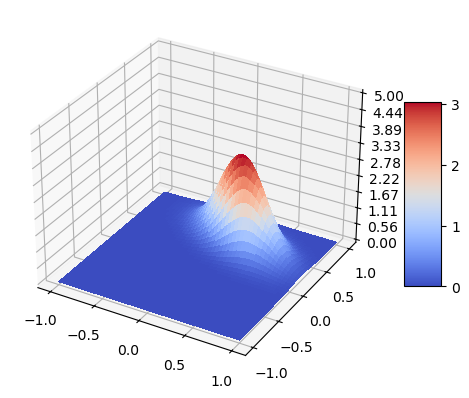

In [25]:
xb = [0.2,0.5]
sb = [0.3,0.2]
rho = -0.5
plotGauss3D(xb[0],xb[1],sb[0],sb[1],rho)

__Notes__:
- Background state vector, xb, or the mean??
- Covariance B-matrix, sb, and correlation coefficient rho. 
- Using the function above, the Gaussian distribution is shown.

- The Gaussian distribution is used to describe the uncertainty of the background and the observations. The peak above shows where there is largest probability that the systems true state lies. Here: before data assimilation, where the true state of the system is based of the background??

## 2. A 2-dimensional data assimilation problem:

In [26]:
import numpy as np
import scipy.optimize

### (a)  Prior estimate (Model Background) $x_b$ and the B-Matrix which is defined by the standard deviation $sd$ and the Pearson correlation coefficient $pcorr$

In [27]:
xb = np.array([0.1,0.5]) # Model Background
sd_0 = 0.3   # Standard deviation of value 1
sd_1 = 0.2   # Standard deviation of value 2
pcorr = 0.29  # Pearson correlation coefficient
# The resulting B-Matrix
B  = np.matrix([[sd_0**2,pcorr*sd_0*sd_1],[pcorr*sd_0*sd_1,sd_1**2]])

In [28]:
B

matrix([[0.09  , 0.0174],
        [0.0174, 0.04  ]])

### (b) Two observation and their uncertainties $x_r$ and their respective standard deviation sd are defined

In [29]:
xr = np.array([0.4,0.1]) # Observation
sd = 0.3 # Standard deviation of the observation
# The resulting R-Matrix
R  = np.matrix([[sd**2,0.0],[0.0,sd**2]])

In [30]:
R

matrix([[0.09, 0.  ],
        [0.  , 0.09]])

### (c) Define the functions
#### Cost ()  -> returns the cost function J and the Jacobian J' 
#### Uncertaintity()-> returns the Hessian J''

In [31]:
def cost(x,xb,B,xr,R):
    Jb = np.dot(np.array(0.5*(xb-x) * B.I),(xb-x))[0]
    Jr = np.dot(np.array(0.5*(xr-x) * R.I),(xr-x))[0]
    JbPrime = -(xb-x)*B.I
    JrPrime = -(xr-x)*R.I
    return Jr+Jb,np.array(JrPrime+JbPrime)[0]

def uncertainty(x,xb,B,xr,R):
    return (B.I + R.I).I

### (d) Algorithm to find the optimal solution $x$
#### The cost function needs to be minimized and reveals the optimal solution $x$(or analysis).
#### The function also computes the  standard deviation and the Person coefficient of the optimal solution 

In [32]:
# starting guess
x = np.array([0.,0.])
retval = scipy.optimize.fmin_l_bfgs_b(cost,x,args=(xb,B,xr,R))
# x new
x = retval[0]
# uncertainty
Cpost = uncertainty(x,xb,B,xr,R)

print ('Results:')
# print prior
psigma0 = np.sqrt(B[0,0]); psigma1 = np.sqrt(B[1,1])
prho12  = B[0,1]/(psigma0*psigma1)
print ('Model background:     xb      =',xb[0],xb[1])
print ('                      sigma   =',psigma0,psigma1)
print ('                      rho     =',prho12)

# print observation
rsigma0 = np.sqrt(R[0,0]); rsigma1 = np.sqrt(R[1,1])
rrho12  = R[0,1]/(rsigma0*rsigma1)
print ('Observation:          xo      =',xr[0],xr[1])
print ('                      sigma   =',rsigma0,rsigma1) 
print ('                      rho     =',rrho12)

sigma0 = np.sqrt(Cpost[0,0]); sigma1 = np.sqrt(Cpost[1,1])
rho12  = Cpost[0,1]/(sigma0*sigma1)
print ('Solution:             x       =',x[0],x[1])
print ('                      sigma   =',sigma0,sigma1)
print ('                      rho     =',rho12)

Results:
Model background:     xb      = 0.1 0.5
                      sigma   = 0.3 0.2
                      rho     = 0.29
Observation:          xo      = 0.4 0.1
                      sigma   = 0.3 0.3
                      rho     = 0.0
Solution:             x       = 0.2209136676070388 0.40089309372028864
                      sigma   = 0.210737128468402 0.1639377160509301
                      rho     = 0.1766258406208834


### (e) Plot the Gaussian distriubtions before and after data assimilation 
#### The Gaussian distributions of the model background (prior), the observations, and the optimal solution (posterior) is visualized below

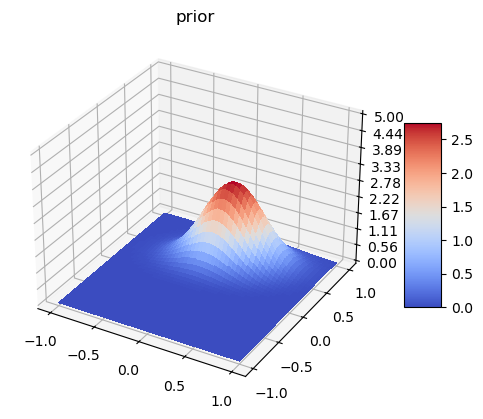

In [33]:
plotGauss3D(xb[0],xb[1],psigma0,psigma1,prho12,vminmax=[0,5],title='prior')

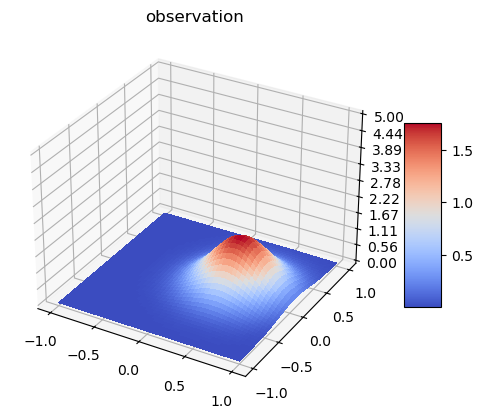

In [34]:
plotGauss3D(xr[0],xr[1],rsigma0,rsigma1,rrho12,vminmax=[0,3],title='observation')

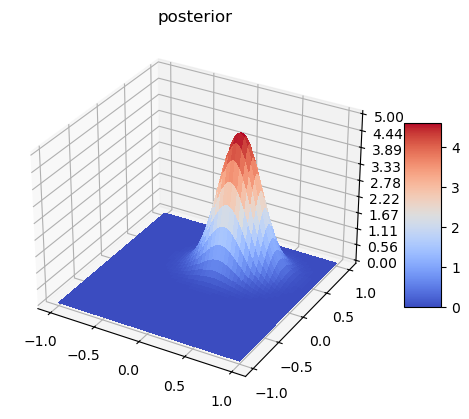

In [35]:
plotGauss3D(x[0],x[1],sigma0,sigma1,rho12,vminmax=[0,5],title='posterior')

__Answers:__
- Describe with your own words the last part, i.e. prior, observation, and posterior and how it relates to what we have talked about in the lectures. + What can you say about the Gaussian distribution of the background compared to the optimal solution?

Prior is the background, the models estimate before observations are taken into account. The Gaussian distribution shows the best guess of the state of the atmosphere, the peak, meaning highest probability. The spread of the distribution shows the uncertainty. 

Observations are the real world measurements to be incorported into the analysis. Observations have errors and uncertainties, so the Gaussian distribution shows which value has the highest probability of being true, while also showing a large(larger) uncertainity.

The posterior would be the analysis where observations has been incorporated into the prior and produced a better guees of the state of the atmosphere based of the uncertainties and correlations. We see that the posterior has the highest peak and smallest spread/uncertainty. 


- How can you interpret the differences between them?

The difference in height of peaks and spread between the background and posterior shows that including observations produces a more certain guess of the state. The difference in spreading indicates how much the observations affect reduces uncertainty. Here both the height of the peak and spreading improved from background to analysis, which means the observations helped.



- Degrade the accuracy significantly of the background and/or observation (of one and both points). What do you observe concerning the optimal solution?

To do this, I think I can increase the variances of for instance the background, to make it more uncertain

In [36]:
B[0,0]*=4
B[1,1]*=4


# starting guess
x = np.array([0.,0.])
retval = scipy.optimize.fmin_l_bfgs_b(cost,x,args=(xb,B,xr,R))
# x new
x = retval[0]
# uncertainty
Cpost = uncertainty(x,xb,B,xr,R)

print ('Results:')
# print prior
psigma0 = np.sqrt(B[0,0]); psigma1 = np.sqrt(B[1,1])
prho12  = B[0,1]/(psigma0*psigma1)
print ('Model background:     xb      =',xb[0],xb[1])
print ('                      sigma   =',psigma0,psigma1)
print ('                      rho     =',prho12)

# print observation
rsigma0 = np.sqrt(R[0,0]); rsigma1 = np.sqrt(R[1,1])
rrho12  = R[0,1]/(rsigma0*rsigma1)
print ('Observation:          xo      =',xr[0],xr[1])
print ('                      sigma   =',rsigma0,rsigma1) 
print ('                      rho     =',rrho12)

sigma0 = np.sqrt(Cpost[0,0]); sigma1 = np.sqrt(Cpost[1,1])
rho12  = Cpost[0,1]/(sigma0*sigma1)
print ('Solution:             x       =',x[0],x[1])
print ('                      sigma   =',sigma0,sigma1)
print ('                      rho     =',rho12)

Results:
Model background:     xb      = 0.1 0.5
                      sigma   = 0.6 0.4
                      rho     = 0.0725
Observation:          xo      = 0.4 0.1
                      sigma   = 0.3 0.3
                      rho     = 0.0
Solution:             x       = 0.3342550672369481 0.2485758473203084
                      sigma   = 0.26823763285970575 0.2398177846364212
                      rho     = 0.019527695701635657


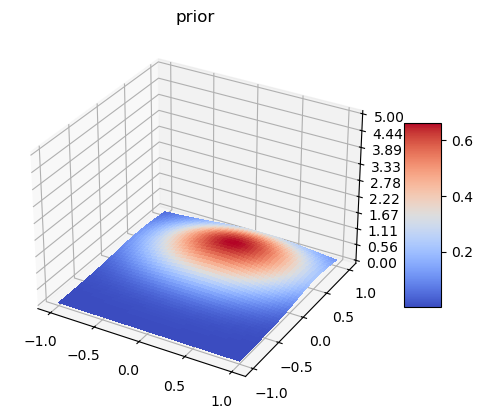

In [37]:
plotGauss3D(xb[0],xb[1],psigma0,psigma1,prho12,vminmax=[0,5],title='prior')

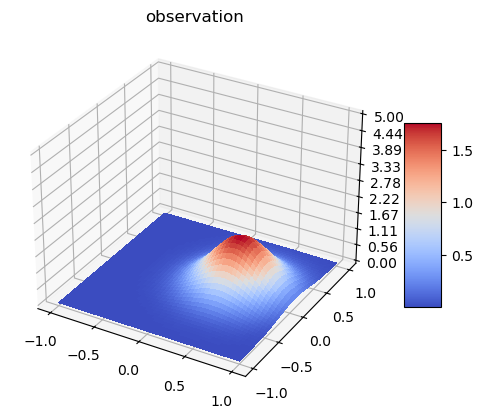

In [38]:
plotGauss3D(xr[0],xr[1],rsigma0,rsigma1,rrho12,vminmax=[0,3],title='observation')

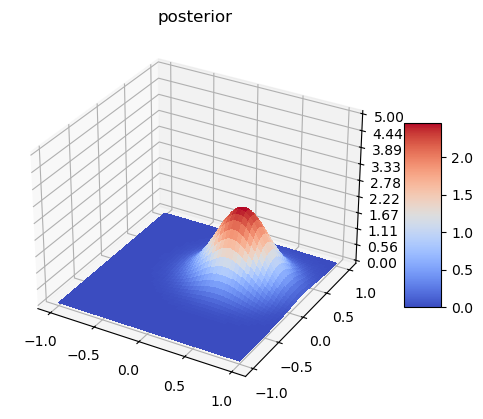

In [39]:
plotGauss3D(x[0],x[1],sigma0,sigma1,rho12,vminmax=[0,5],title='posterior')

By increasing the variances of the B matrix, meaning the background being more uncertain, we see that the posterior also loses its certainty. Meaning a lower peak than in the example before.